(30, 4)
File is saved as order_manual.csv
Cumulative return of the benchmark:  1.03164
Stdev of the benchmark:  0.073551836669
Mean of the benchmark:  0.899529227723
Cumulative return of the df_manual:  1.11948
Stdev of the df_manual:  0.0299626532231
Mean of the df_manual:  1.07690782961
Cumulative return of the ml:  1.22488
Stdev of the ml:  0.0647162586427
Mean of the ml:  1.14417920792


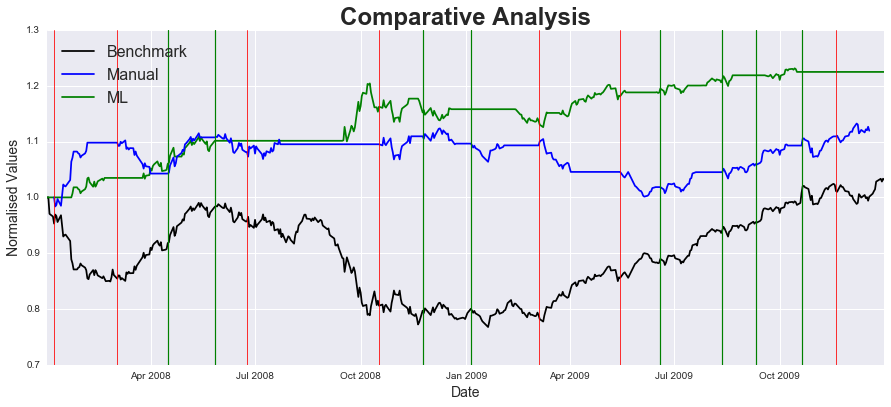

In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt
import os
from util import get_data, plot_data
import matplotlib.pyplot as plt
import seaborn as sns
from indicators import indicators
from rule_based import rule_based
from ml_based import ml_based
from rule_based import rule_based

def author():
        return 'llee81'
    

def compute_portvals2(orders_file="./orders/orders.csv", start_val=1000000):
    orders_df = pd.read_csv(orders_file, index_col='Date', parse_dates=True, na_values=['nan'])

    # GET PRICES OF ALL USED SYMBOLS
    start_date = orders_df.index[0]
    end_date = orders_df.index[-1]
    list_symbols = [i for i in orders_df.Symbol.unique()]
    all_symbols = get_data(list_symbols, pd.date_range(start_date, end_date))
    orders_df_full = pd.DataFrame(index=all_symbols.index)  # SAVE ALL DAYS DATA

    # ADD ALL SYMBOLS IN orders_df
    for sym in list_symbols:
        orders_df.ix[0, sym] = "0"
        orders_df_full.ix[0, sym] = "0"

    # POPULATE THE
    orders_df.ix[0, "cash"] = start_val
    orders_df.ix[0, "value"] = start_val
    orders_df_full.ix[0, "cash"] = start_val
    orders_df_full.ix[0, "Symbol"] = ''
    orders_df_full.ix[0, "Order"] = ''
    orders_df_full.ix[0, "Shares"] = ''
    orders_df_full.ix[0, "stock_price"] = ''
    orders_df_full.ix[0, "cash_used"] = ''
    orders_df_full.ix[0, "value"] = ''
    orders_df_full.ix[0, "leverage"] = ''
    orders_df_full = orders_df_full.fillna(0)
    orders_df = orders_df.fillna(0)

    # SAME DAY ORDER
    for i in range(orders_df.shape[0]):
        if i > 0:
            if orders_df.index[i] == orders_df.index[i - 1] and orders_df.ix[i, "Symbol"] == orders_df.ix[
                        i - 1, "Symbol"]:
                sym = orders_df.ix[i, "Symbol"]
                prev_add_amt = float(orders_df.ix[i - 1, "Shares"]) if orders_df.ix[
                                                                           i - 1, 'Order'] == 'BUY' else -float(
                    orders_df.ix[i - 1, "Shares"])
                add_amt = float(orders_df.ix[i, "Shares"]) if orders_df.ix[i, 'Order'] == 'BUY' else -float(
                    orders_df.ix[i, "Shares"])

                orders_df.ix[i - 1, "Shares"] = 0
                final_amt = add_amt + prev_add_amt
                orders_df.ix[i, "Shares"] = np.absolute(final_amt)
                orders_df.ix[i, "Order"] = 'BUY' if final_amt >= 0 else 'SELL'

    # COMPRESS ORDER
    for i in range(orders_df.shape[0]):
        sym = orders_df.ix[i, "Symbol"]
        add_amt = float(orders_df.ix[i, "Shares"]) if orders_df.ix[i, 'Order'] == 'BUY' else -float(
            orders_df.ix[i, "Shares"])
        orders_df.ix[orders_df.index[i], sym] = add_amt

    # REMOVE DUPLICATE DAYS
    orders_df = orders_df.groupby(orders_df.index).first()
    orders_df.ix[:, 'date1'] = orders_df.index
    orders_df_full.ix[:, 'date1'] = orders_df_full.index

    # COUNT ORDER VALUE
    for i in range(orders_df.shape[0]):
        stock_value = 0
        leverage_stocks = 0
        for sym in list_symbols:
            stock_value = stock_value + float(orders_df.ix[i, sym]) * float(
                all_symbols.ix[orders_df.index[i], sym]) * -1
            leverage_stocks = leverage_stocks + np.absolute(float(orders_df.ix[i, sym])) * float(
                all_symbols.ix[orders_df.index[i], sym])
            orders_df.ix[i, sym + '_p'] = float(orders_df.ix[i, sym]) * float(
                all_symbols.ix[orders_df.index[i], sym]) * -1

        orders_df.ix[i, 'cash_impact'] = stock_value
        orders_df.ix[i, 'leverage_stocks'] = leverage_stocks

    def get_order_values(df_row):
        stock_value = 0
        leverage_stocks = 0
        for sym in list_symbols:
            if pd.isnull(df_row[sym]) == False:
                stock_value = stock_value + float(df_row[sym]) * float(all_symbols.ix[df_row.ix['date1'], sym])
                leverage_stocks = leverage_stocks + np.absolute(
                    float(df_row[sym]) * float(all_symbols.ix[df_row.ix['date1'], sym]))
        return stock_value, leverage_stocks

    leverage = 0
    stock_value = 0
    cash = start_val

    # init first row
    orders_df_full.ix[0, :] = orders_df.ix[0, :]
    current_stock_value, current_leverage = get_order_values(orders_df_full.loc[orders_df_full.index[0], :])
    orders_df_full.ix[0, "cash"] = orders_df_full.ix[0, "cash"] + orders_df.ix[0, 'cash_impact']
    orders_df_full.ix[0, "value"] = current_stock_value + orders_df_full.ix[0, "cash"]
    orders_df_full.ix[0, "leverage"] = current_leverage / orders_df_full.ix[0, "value"]
    if orders_df_full.ix[0, "leverage"] > 1.5:
        for sym in list_symbols:
            orders_df_full.ix[0, sym] = 0
        orders_df_full.ix[0, 'overleverage'] = orders_df_full.ix[0, "leverage"]
        orders_df_full.ix[0, "cash"] = start_val

    for i in range(1, orders_df_full.shape[0]):

        # copy down all symbol holdings
        for sym in list_symbols:
            orders_df_full.ix[i, sym] = orders_df_full.ix[i - 1, sym]
            orders_df_full.ix[i, "cash"] = orders_df_full.ix[i - 1, "cash"]

        # ADD NEW ORDER STOCKS
        if orders_df_full.index[i] in orders_df.index:
            for sym in list_symbols:
                orders_df_full.ix[i, sym] = float(orders_df_full.ix[i, sym]) + float(
                    orders_df.ix[orders_df_full.index[i], sym])
            orders_df_full.ix[i, "cash"] = orders_df_full.ix[i, "cash"] + orders_df.ix[
                orders_df_full.index[i], 'cash_impact']
            # check overleverage
            current_stock_value, current_leverage = get_order_values(orders_df_full.loc[orders_df_full.index[i], :])
            order_total_value = current_stock_value + orders_df_full.ix[i, "cash"]
            order_total_leverage = current_leverage / order_total_value
            if order_total_leverage > 1.5:
                for sym in list_symbols:
                    orders_df_full.ix[i, sym] = orders_df_full.ix[i - 1, sym]
                orders_df_full.ix[i, 'overleverage'] = order_total_leverage
                orders_df_full.ix[i, "cash"] = orders_df_full.ix[i - 1, "cash"]

        current_stock_value, current_leverage = get_order_values(orders_df_full.loc[orders_df_full.index[i], :])
        orders_df_full.ix[i, "value"] = current_stock_value + orders_df_full.ix[i, "cash"]
        orders_df_full.ix[i, "leverage"] = current_leverage / orders_df_full.ix[i, "value"]

    #orders_df_full.to_csv("orders_df_full.csv")
    return orders_df_full.value


def test_code(DRAW=True,VERBOSE=False,YBUY= 0.1,YSELL= -0.1,BAGS = 20):
    of = "./orders/orderAAPL.csv"
    sv = 100000

    # Process orders
    portvals = compute_portvals2(orders_file = of, start_val = sv)
    portvals = portvals/portvals.ix[0,0]
    
    if isinstance(portvals, pd.DataFrame):
        portvals = portvals[portvals.columns[0]] # just get the first column
    else:
        "warning, code did not return a DataFrame"
    
    #generate file and signals
    #signal,signal_close,signal_merge,df_main_lines = ml_based(YBUY= YBUY,YSELL= YSELL,BAGS = BAGS)
    signal,signal_close,signal_merge,df_main_lines = rule_based()
    
    # Process orders
    df_manual = compute_portvals2(orders_file = "order_manual.csv", start_val = sv)
    df_manual = df_manual/df_manual.ix[0,0]
    df_max = pd.DataFrame(index=portvals.index)
    
    df_temp = compute_portvals2(orders_file = "order_ml.csv", start_val = sv)
    df_temp = df_temp/df_temp.ix[0,0]
    temp_value = 1.
    for i in df_max.index:
        if i not in df_temp:
             df_max.ix[i,'port'] = temp_value
        else:
            df_max.ix[i,'port'] = df_temp.ix[i]
            temp_value = df_temp.ix[i]
    
    #DRAW GRAPH
    if DRAW:
        plt.rcParams["figure.figsize"] = [15,6]
        plt.title('Comparative Analysis', fontsize=24, fontweight='bold')
        plt.ylabel('Normalised Values', fontsize=14)
        plt.xlabel('Date', fontsize=14)
        line_price, = plt.plot(portvals)
        line_port_ml, = plt.plot(df_max)
        line_manual, = plt.plot(df_manual)
        plt.setp(line_price, color='black')
        plt.setp(line_manual, color='b')
        plt.setp(line_port_ml, color='g')
        plt.legend([line_price,line_manual,line_port_ml], ['Benchmark','Manual','ML'], fontsize=16, loc=0)

        df_lines = signal
        ax = plt.gca()
        df_buy = df_lines[df_lines.Order=="BUY"]
        for i in df_buy.index :
            ax.axvline(i, color='g', linestyle='-', lw=1.2)

        df_sell = df_lines[df_lines.Order=="SELL"]
        for i in df_sell.index :
            ax.axvline(i, color='r', linestyle='-', lw=0.8)

        plt.savefig('ComparativeAnalysis.png', bbox_inches='tight')
        
    # Get portfolio stats
    # Here we just fake the data. you should use your code from previous assignments.
    start_date = dt.datetime(2008,1,1)
    end_date = dt.datetime(2008,6,1)
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = [0.2,0.01,0.02,1.5]
    cum_ret_SPY, avg_daily_ret_SPY, std_daily_ret_SPY, sharpe_ratio_SPY = [0.2,0.01,0.02,1.5]

    if VERBOSE:
        print 'Cumulative return of the benchmark: ',portvals[-1]
        print 'Stdev of the benchmark: ',portvals.std()
        print 'Mean of the benchmark: ',portvals.mean()
        print 'Cumulative return of the df_manual: ',df_manual[-1]
        print 'Stdev of the df_manual: ',df_manual.std()
        print 'Mean of the df_manual: ',df_manual.mean()
        print 'Cumulative return of the ml: ',df_max.port[-1]
        print 'Stdev of the ml: ',df_max.port.std()
        print 'Mean of the ml: ',df_max.port.mean()
      
        #print 'Cumulative return of the best portfolio: ',df_max[-1]
        #print 'Stdev of the  best portfolio: ',df_max.port.std()
        #print 'Mean of the  best portfolio: ',df_max.port.mean()
    #return df_max[-1]
if __name__ == "__main__":
    test_code(VERBOSE=True,DRAW=True)
    


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import seaborn as sns
from util import get_data, plot_data
from indicators import indicators

def rule_based():
    start_date = dt.datetime(2010,1,1)
    end_date = dt.datetime(2012,12,31)
    symbols = ['AAPL']
    df = indicators(sd = start_date, ed = end_date,\
        syms = symbols,gen_plot = False,n=10,verbose=False)

    df_close = pd.DataFrame(index=df.index)

    remaining_days=0
    last_order=''
    for i in range(df.shape[0]):
        remaining_days = remaining_days -1

        df.ix[i,'remaining_days'] = remaining_days
        if remaining_days==1:
                df_close.ix[i,'Order'] = "BUY" if  last_order=="SELL" else "SELL"
                last_order=''

        if remaining_days <=1:
            lookback=4
            if df.ix[i,'momentum']>0:
                #if df.ix[i,'sma']>0 and (df.ix[i-lookback:i,'sma']<0).any() or df.ix[i,'ema']>0 and (df.ix[i-lookback:i,'ema']<0).any() :
                if  df.ix[i,'sma']>0 and df.ix[i,'ema']>0 and (df.ix[i-lookback:i,'ema']<0).any()  :
                    df.ix[i,'Order'] = "BUY"
                    remaining_days = 21
                    last_order='BUY'
                    df.ix[i,'remaining_days'] = remaining_days
            else:
                #if df.ix[i,'sma']<0 and (df.ix[i-lookback:i,'sma']>0).any() or df.ix[i,'ema']<0 and (df.ix[i-lookback:i,'ema']>0).any() :
                if df.ix[i,'sma']<0 and df.ix[i,'ema']<0 and (df.ix[i-lookback:i,'ema']>0).any()  :
                    df.ix[i,'Order'] = "SELL"
                    remaining_days = 21
                    last_order='SELL'
                    df.ix[i,'remaining_days'] = remaining_days

    signal_close = pd.DataFrame(data=df_close.Order, index=df_close.index)
    signal_close = signal_close[pd.isnull(signal_close.Order)==False]

    signal = pd.DataFrame(data=df.Order, index=df.index)
    signal = signal[pd.isnull(signal.Order)==False]

    signal_merge = pd.concat([signal,signal_close])
    signal_merge = signal_merge.sort_index()
    signal_merge.ix[:,'Date'] = signal_merge.index
    signal_merge.ix[:,'Symbol'] = 'AAPL'
    signal_merge.ix[:,'Shares'] = '200'
    signal_merge.to_csv('order_manual_os.csv',index=False)
    print signal_merge.shape
    print 'File is saved as order_manua_osl.csv'
    return signal,signal_close,signal_merge,df

if __name__ == "__main__":
    rule_based()


(53, 4)
File is saved as order_manua_osl.csv


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
import seaborn as sns
from indicators import indicators
from util import get_data
from datetime import datetime, timedelta
import RTLearner as rt
import BagLearner as bl
from indicators import indicators

def ml_based(YBUY= 0.1,YSELL= -0.1,BAGS = 20):
    #INDICATORS
    start_date = dt.datetime(2010,1,1)
    end_date = dt.datetime(2012,12,31)
    df = indicators(sd = start_date, ed = end_date,syms = ['AAPL'],gen_plot = False,n=10,verbose=False)
    dates = pd.date_range(df.index[0]+timedelta(days=-50), df.index[-1])

    prices_all = get_data(['AAPL'], dates)
    prices_all.ix[:,'return'] = ( prices_all.ix[21:,'AAPL'] /prices_all.ix[0:-21,'AAPL'].values ) -1
    df.ix[:,'return'] = prices_all.ix[:,'return']
    for i in df.index:
        if df.ix[i,'return']>YBUY:
            df.ix[i,'Y'] = 1
        elif df.ix[i,'return']<YSELL:
            df.ix[i,'Y'] = -1
        else:
            df.ix[i,'Y'] = 0

    tx = df[['sma_zscore','ema_zscore','momentum_zscore']].values
    ty=df['Y'].values
    #learner = rt.RTLearner(LEAVE_SIZE) # create a RTLearner
    learner = bl.BagLearner(bags=BAGS)
    learner.addEvidence(tx, ty) # train it
    predY = learner.query(tx) # get the predictions

    #SETUP THE ORDERING
    df_close = pd.DataFrame(index=df.index)
    remaining_days=0
    last_order=''
    for i in range(df.shape[0]):
        remaining_days = remaining_days -1

        df.ix[i,'remaining_days'] = remaining_days
        if remaining_days==1:
                df_close.ix[i,'Order'] = "BUY" if  last_order=="SELL" else "SELL"
                last_order=''

        if remaining_days <=1:
            if predY[i]==1:
                df.ix[i,'Order'] = "BUY"
                remaining_days = 21
                last_order='BUY'
                df.ix[i,'remaining_days'] = remaining_days
            elif predY[i]==-1:
                df.ix[i,'Order'] = "SELL"
                remaining_days = 21
                last_order='SELL'
                df.ix[i,'remaining_days'] = remaining_days

    signal_close = pd.DataFrame(data=df_close.Order, index=df_close.index)
    signal_close = signal_close[pd.isnull(signal_close.Order)==False]

    signal = pd.DataFrame(data=df.Order, index=df.index)
    signal = signal[pd.isnull(signal.Order)==False]

    signal_merge = pd.concat([signal,signal_close])
    signal_merge = signal_merge.sort_index()
    signal_merge.ix[:,'Date'] = signal_merge.index
    signal_merge.ix[:,'Symbol'] = 'AAPL'
    signal_merge.ix[:,'Shares'] = '200'
    signal_merge.to_csv('order_ml_os.csv',index=False)
    print signal_merge.shape
    print 'File is saved as order_ml_os.csv'
    return signal,signal_close,signal_merge,df

if __name__ == "__main__":
    ml_based()


(15, 4)
File is saved as order_ml_os.csv
